# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [10]:
!pip install rioxarray geopandas rasterio pyproj pystac_client planetary_computer pystac

In [11]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [12]:
# Load the training data from csv file and display the first few rows to inspect the data
df = pd.read_csv("/kaggle/input/uhi-index-data/Training_data_uhi_index_UHI2025-v2.csv")
df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

In [13]:
# # Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# # Open the GeoTIFF file
# tiff_path = "/kaggle/input/sentinel2-ey/Sentinel2_Median_All_Bands_and_Indices.tiff"

# # Read the bands from the GeoTIFF file
# with rasterio.open(tiff_path) as src1:
#     band1 = src1.read(1)  # Band [B01]
#     band2 = src1.read(2)  # Band [B02]
#     band3 = src1.read(3)  # Band [B03]
#     band4 = src1.read(4)  # Band [B04]

# # Plot the bands in a 2x2 grid
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# # Flatten the axes for easier indexing
# axes = axes.flatten()

# # Plot the first band (B01)
# im1 = axes[0].imshow(band1, cmap='viridis')
# axes[0].set_title('Band [B01]')
# fig.colorbar(im1, ax=axes[0])

# # Plot the second band (B04)
# im2 = axes[1].imshow(band2, cmap='viridis')
# axes[1].set_title('Band [B02]')
# fig.colorbar(im2, ax=axes[1])

# # Plot the third band (B06)
# im3 = axes[2].imshow(band3, cmap='viridis')                 
# axes[2].set_title('Band [B03]')
# fig.colorbar(im3, ax=axes[2])

# # Plot the fourth band (B08)
# im4 = axes[3].imshow(band4, cmap='viridis')
# axes[3].set_title('Band [B04]')
# fig.colorbar(im4, ax=axes[3])

# plt.tight_layout()
# plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [14]:
%config Completer.use_jedi = True

In [15]:
def map_satellite_data(tiff_path, csv_path):
    """
    Maps all bands and derived features from a GeoTIFF file to coordinates in a CSV file.

    Parameters:
    - tiff_path (str): Path to the GeoTIFF file containing all bands and features.
    - csv_path (str): Path to the CSV file containing Latitude and Longitude columns.

    Returns:
    - pd.DataFrame: DataFrame with extracted values for each band and feature.
    """
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path, masked=True)
    tiff_crs = data.rio.crs

    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Create a dictionary to store extracted values
    extracted_data = {band: [] for band in data.band.values}

    # Iterate over the latitudes and longitudes to extract corresponding values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        for band in data.band.values:
            try:
                # Extract the value for the current band and append it
                value = data.sel(x=lon, y=lat, band=band, method="nearest").values
                extracted_data[band].append(value)
            except Exception as e:
                # Handle missing data or errors
                extracted_data[band].append(None)

    # Convert the extracted data into a DataFrame
    feature_df = pd.DataFrame(extracted_data)

    # Rename columns to meaningful names if needed
    band_names = {
        1: "B01", 2: "B02", 3: "B03", 4: "B04", 5: "B05",
        6: "B06", 7: "B07", 8: "B08", 9: "B8A", 10: "B11", 11: "B12",
        12: "SCL", 13: "WVP", 14: "AOT", 15: "NDVI", 16: "NDBI",
        17: "NDWI", 18: "EVI", 19: "SAVI", 20: "MSAVI", 21: "GNDVI",
        22: "IBI", 23: "UI", 24: "NDBSI", 25: "NDMI", 26: "NDSI", 27: "BI",
        28: "REP", 29: "NGRDI", 30: "MNDWI", 31: "NDWI_Variant", 32: "BSI",
        33: "SBI", 34: "Albedo", 35: "Vegetation_Ratio", 36: "Bare_Soil_Ratio",
        37: "Water_Ratio", 38: "Urban_Ratio", 39: "Cloud_Shadow_Ratio", 40: "Cloud_Percentage"
    }

    feature_df.rename(columns=band_names, inplace=True)

    # Combine the extracted features with the original CSV
    final_df = pd.concat([df, feature_df], axis=1)

    return final_df


In [16]:
mean_tiff_path = '/kaggle/input/sentinel2-ey/Sentinel2_Mean_All_Bands_and_Indices.tiff'
median_tiff_path = '/kaggle/input/sentinel2-ey/Sentinel2_Median_All_Bands_and_Indices.tiff'
single_date_tiff_path = '/kaggle/input/sentinel2-ey/Sentinel2_SingleDate_All_Bands_and_Indices.tiff'
single_date_masked_tiff_path = '/kaggle/input/sentinel2-ey/Sentinel2_SingleDate_CloudMasked_All_Bands_and_Indices.tiff'
weighted_mosaic_tiff_path = '/kaggle/input/weighted-mosaic-old-version-check-dataset/Sentinel2_WeightedMosaic_All_Bands_and_Indices.tiff'
test_path = "/kaggle/input/weighted-mosaic-old-version-check-dataset/Sentinel2_WeightedMosaic_All_Bands_and_Indices.tiff"

In [17]:
# import rasterio
# import numpy as np
# from rasterio.transform import rowcol
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm

# def diagnose_tiff_file(tiff_path, coordinates_df=None):
#     """
#     Comprehensive diagnostic function for analyzing a GeoTIFF file and its relation
#     to provided coordinates.
    
#     Parameters:
#     -----------
#     tiff_path : str
#         Path to the GeoTIFF file
#     coordinates_df : pandas.DataFrame, optional
#         DataFrame containing Latitude and Longitude columns
#     """
#     with rasterio.open(tiff_path) as src:
#         print("\n=== TIFF File Basic Information ===")
#         print(f"Driver: {src.driver}")
#         print(f"Width: {src.width}, Height: {src.height}")
#         print(f"Bounds: {src.bounds}")
#         print(f"CRS: {src.crs}")
#         print(f"Transform: {src.transform}")
#         print(f"Number of bands: {src.count}")
        
#         # Analyze each band
#         print("\n=== Band Statistics ===")
#         for band_idx in range(1, src.count + 1):
#             band_data = src.read(band_idx)
#             non_zero = np.count_nonzero(band_data)
#             total_pixels = band_data.size
#             zero_percentage = (1 - non_zero/total_pixels) * 100
            
#             print(f"\nBand {band_idx}:")
#             print(f"Min: {np.nanmin(band_data):.6f}")
#             print(f"Max: {np.nanmax(band_data):.6f}")
#             print(f"Mean: {np.nanmean(band_data):.6f}")
#             print(f"Zero pixels: {zero_percentage:.2f}%")
#             print(f"NaN count: {np.isnan(band_data).sum()}")
            
#             # Create histogram for non-zero values
#             non_zero_values = band_data[band_data != 0]
#             if len(non_zero_values) > 0:
#                 plt.figure(figsize=(10, 4))
#                 plt.hist(non_zero_values.ravel(), bins=50)
#                 plt.title(f'Band {band_idx} - Non-zero values distribution')
#                 plt.xlabel('Value')
#                 plt.ylabel('Frequency')
#                 plt.show()
        
#         # Coordinate analysis if provided
#         if coordinates_df is not None:
#             print("\n=== Coordinate Analysis ===")
#             coords_inside = 0
#             unique_pixels = set()
            
#             for idx in tqdm(range(len(coordinates_df)), desc="Analyzing coordinates"):
#                 row = coordinates_df.iloc[idx]
#                 row_px, col_px = rowcol(src.transform, row['Longitude'], row['Latitude'])
                
#                 if (0 <= row_px < src.height and 0 <= col_px < src.width):
#                     coords_inside += 1
#                     unique_pixels.add((row_px, col_px))
            
#             print(f"Total coordinates: {len(coordinates_df)}")
#             print(f"Coordinates inside raster bounds: {coords_inside}")
#             print(f"Unique pixel locations: {len(unique_pixels)}")
#             print(f"Coordinate to pixel ratio: {len(unique_pixels)/len(coordinates_df):.2%}")

# def visualize_coordinate_coverage(tiff_path, coordinates_df, band_idx=1):
#     """
#     Visualize where the coordinates fall on the raster data.
    
#     Parameters:
#     -----------
#     tiff_path : str
#         Path to the GeoTIFF file
#     coordinates_df : pandas.DataFrame
#         DataFrame containing Latitude and Longitude columns
#     band_idx : int
#         Band index to use for background visualization
#     """
#     with rasterio.open(tiff_path) as src:
#         # Read the specified band
#         band_data = src.read(band_idx)
        
#         plt.figure(figsize=(15, 10))
        
#         # Plot the raster data
#         plt.imshow(band_data, cmap='viridis')
        
#         # Convert coordinates to pixel locations
#         pixel_coords = []
#         for idx in range(len(coordinates_df)):
#             row = coordinates_df.iloc[idx]
#             row_px, col_px = rowcol(src.transform, row['Longitude'], row['Latitude'])
#             pixel_coords.append((row_px, col_px))
        
#         # Plot coordinate points
#         pixel_coords = np.array(pixel_coords)
#         plt.scatter(pixel_coords[:, 1], pixel_coords[:, 0], 
#                    c='red', s=1, alpha=0.5, label='Coordinates')
        
#         plt.colorbar(label='Band Value')
#         plt.title(f'Coordinate Coverage on Band {band_idx}')
#         plt.legend()
#         plt.show()

# diagnose_tiff_file('/kaggle/input/landsat-lst/Landsat8_WeightedMosaic_10m.tiff')
# coords_df = pd.read_csv('/kaggle/input/uhi-index-data/Training_data_uhi_index_UHI2025-v2.csv')
# visualize_coordinate_coverage(test_path, coords_df)

In [18]:
# Mapping satellite data with training data.
final_data = map_satellite_data(test_path, '/kaggle/input/uhi-index-data/Training_data_uhi_index_UHI2025-v2.csv')
# final_data = pd.read_csv('/kaggle/input/final-data-weighted-mosaiclandsat-sentinel-2/final_data_weighted_mosaic.csv')

Mapping values: 100%|██████████| 11229/11229 [11:38<00:00, 16.07it/s]


In [19]:
final_data.to_csv('sentinel_wm_nbs_train.csv', index=False)

In [20]:
cols = [col for col in final_data.columns if col!='Latitude' and col!='Longitude' and col!='datetime' and col!='UHI Index']
cols

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B11',
 'B12',
 'SCL',
 'WVP',
 'AOT',
 'NDVI',
 'NDBI',
 'NDWI',
 'EVI',
 'SAVI',
 'MSAVI',
 'GNDVI',
 'IBI',
 'UI',
 'NDBSI',
 'NDMI',
 'NDSI',
 'BI',
 'REP',
 'NGRDI',
 'MNDWI',
 'NDWI_Variant',
 'BSI',
 'SBI',
 'Albedo',
 'Vegetation_Ratio',
 'Bare_Soil_Ratio',
 'Water_Ratio',
 'Urban_Ratio',
 'Cloud_Shadow_Ratio']

In [21]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
# final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
# final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

In [22]:
X = final_data[cols]
y = df['UHI Index']

In [23]:
for col in X.columns:
    print(f'{col} missing values :', X[col].isnull().sum())

B01 missing values : 0
B02 missing values : 0
B03 missing values : 0
B04 missing values : 0
B05 missing values : 0
B06 missing values : 0
B07 missing values : 0
B08 missing values : 0
B8A missing values : 0
B11 missing values : 0
B12 missing values : 0
SCL missing values : 0
WVP missing values : 0
AOT missing values : 0
NDVI missing values : 0
NDBI missing values : 0
NDWI missing values : 0
EVI missing values : 0
SAVI missing values : 0
MSAVI missing values : 0
GNDVI missing values : 0
IBI missing values : 0
UI missing values : 0
NDBSI missing values : 0
NDMI missing values : 0
NDSI missing values : 0
BI missing values : 0
REP missing values : 0
NGRDI missing values : 0
MNDWI missing values : 0
NDWI_Variant missing values : 0
BSI missing values : 0
SBI missing values : 0
Albedo missing values : 0
Vegetation_Ratio missing values : 0
Bare_Soil_Ratio missing values : 0
Water_Ratio missing values : 0
Urban_Ratio missing values : 0
Cloud_Shadow_Ratio missing values : 0


In [24]:
for col in X.columns:
    X[col] = X[col].astype('float64')

In [25]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# tomorrow testing new features to be made from data from sentinel 2

In [26]:
X.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11',
       'B12', 'SCL', 'WVP', 'AOT', 'NDVI', 'NDBI', 'NDWI', 'EVI', 'SAVI',
       'MSAVI', 'GNDVI', 'IBI', 'UI', 'NDBSI', 'NDMI', 'NDSI', 'BI', 'REP',
       'NGRDI', 'MNDWI', 'NDWI_Variant', 'BSI', 'SBI', 'Albedo',
       'Vegetation_Ratio', 'Bare_Soil_Ratio', 'Water_Ratio', 'Urban_Ratio',
       'Cloud_Shadow_Ratio'],
      dtype='object')

In [27]:
X

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,MNDWI,NDWI_Variant,BSI,SBI,Albedo,Vegetation_Ratio,Bare_Soil_Ratio,Water_Ratio,Urban_Ratio,Cloud_Shadow_Ratio
0,810.375000,995.500000,1114.625000,1151.875000,1393.875,1575.125000,1645.500000,1819.000000,1670.625000,1669.000000,...,-0.199156,-0.199623,0.001131,2314.036712,1320.325000,13.304345,31.627396,17.92621,31.627396,0.133534
1,880.222222,680.888889,841.000000,785.555556,1142.000,1892.111111,2114.888889,2218.444444,2281.222222,1580.666667,...,-0.305437,-0.461281,-0.101245,1955.220101,1233.866667,13.304345,31.627396,17.92621,31.627396,0.133534
2,880.222222,680.888889,841.000000,785.555556,1142.000,1892.111111,2114.888889,2218.444444,2281.222222,1580.666667,...,-0.305437,-0.461281,-0.101245,1955.220101,1233.866667,13.304345,31.627396,17.92621,31.627396,0.133534
3,880.222222,665.777778,790.888889,740.111111,1142.000,1892.111111,2114.888889,2189.333333,2281.222222,1580.666667,...,-0.333021,-0.485117,-0.103235,1916.188092,1211.733333,13.304345,31.627396,17.92621,31.627396,0.133534
4,880.222222,667.666667,801.777778,735.222222,1083.000,1803.888889,2073.000000,2156.888889,2224.000000,1600.555556,...,-0.332501,-0.470035,-0.094718,1935.246084,1205.844444,13.304345,31.627396,17.92621,31.627396,0.133534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,460.875000,622.250000,752.250000,631.625000,935.625,2318.000000,2798.250000,2597.500000,3021.875000,1738.000000,...,-0.395844,-0.601365,-0.152097,1996.365248,1353.200000,13.304345,31.627396,17.92621,31.627396,0.133534
11225,460.875000,526.625000,730.000000,534.500000,935.625,2318.000000,2798.250000,3205.750000,3021.875000,1738.000000,...,-0.408428,-0.610861,-0.243115,1959.396399,1310.200000,13.304345,31.627396,17.92621,31.627396,0.133534
11226,460.875000,526.625000,730.000000,534.500000,935.625,2318.000000,2798.250000,3205.750000,3021.875000,1738.000000,...,-0.408428,-0.610861,-0.243115,1959.396399,1310.200000,13.304345,31.627396,17.92621,31.627396,0.133534
11227,460.875000,526.625000,730.000000,534.500000,935.625,2318.000000,2798.250000,3205.750000,3021.875000,1738.000000,...,-0.408428,-0.610861,-0.243115,1959.396399,1310.200000,13.304345,31.627396,17.92621,31.627396,0.133534


In [28]:
import xgboost as xgb
import lightgbm as lgb
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

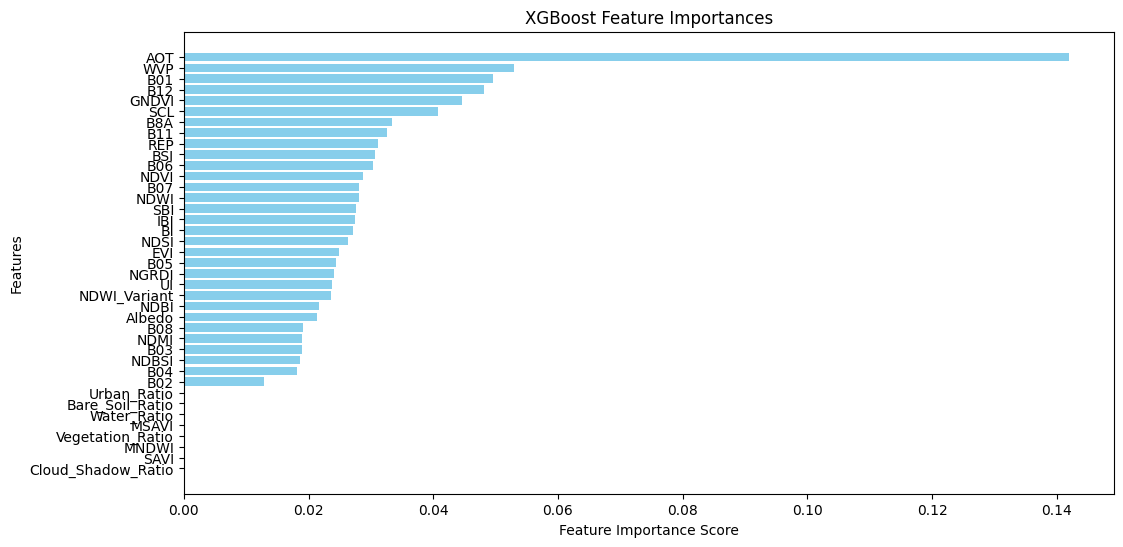

In [29]:
# Get Feature Importances
feature_importances = xgb_reg.feature_importances_
feature_names = X.columns

# Convert to DataFrame for sorting
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()  # Invert axis for better readability
plt.show()

In [30]:
test = map_satellite_data(test_path, '/kaggle/input/test-df-ey-open-science/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [01:06<00:00, 15.75it/s]


In [31]:
test.to_csv('sentinel_wm_nbs_test.csv', index=False)

In [32]:
for col in test.columns:
    print(f'{col} missing values :', test[col].isnull().sum())

Longitude missing values : 0
Latitude missing values : 0
UHI Index missing values : 1040
B01 missing values : 0
B02 missing values : 0
B03 missing values : 0
B04 missing values : 0
B05 missing values : 0
B06 missing values : 0
B07 missing values : 0
B08 missing values : 0
B8A missing values : 0
B11 missing values : 0
B12 missing values : 0
SCL missing values : 0
WVP missing values : 0
AOT missing values : 0
NDVI missing values : 0
NDBI missing values : 0
NDWI missing values : 0
EVI missing values : 0
SAVI missing values : 0
MSAVI missing values : 0
GNDVI missing values : 0
IBI missing values : 0
UI missing values : 0
NDBSI missing values : 0
NDMI missing values : 0
NDSI missing values : 0
BI missing values : 0
REP missing values : 0
NGRDI missing values : 0
MNDWI missing values : 0
NDWI_Variant missing values : 0
BSI missing values : 0
SBI missing values : 0
Albedo missing values : 0
Vegetation_Ratio missing values : 0
Bare_Soil_Ratio missing values : 0
Water_Ratio missing values : 0
U

In [33]:
test = test[cols]
test.head(5)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,MNDWI,NDWI_Variant,BSI,SBI,Albedo,Vegetation_Ratio,Bare_Soil_Ratio,Water_Ratio,Urban_Ratio,Cloud_Shadow_Ratio
0,770.0,454.0,587.0,491.42857142857144,1036.0,2166.8571428571427,2506.4285714285716,2326.285714285714,2633.5714285714284,1654.857142857143,...,-0.47632702478812206,-0.6354684173172462,-0.128689903149104,1823.354930912145,1164.1714285714286,13.304345166655093,31.62739584263236,17.926209534767615,31.62739584263236,0.1335340269994148
1,1184.7142857142858,658.8571428571429,812.2857142857143,711.2857142857143,1257.857142857143,2398.714285714286,2732.5714285714284,2870.8571428571427,2900.8571428571427,1966.0,...,-0.41526120937885647,-0.5624807633117882,-0.137333425395291,2242.964879123075,1409.8571428571427,13.304345166655093,31.62739584263236,17.926209534767615,31.62739584263236,0.1335340269994148
2,1033.0,888.25,1007.875,1071.625,1011.0,1354.125,1515.25,1420.0,1541.625,1440.875,...,-0.17682491066870853,-0.2093547754461659,0.04236892599699217,2059.2020109438026,1190.05,13.304345166655093,31.62739584263236,17.926209534767615,31.62739584263236,0.1335340269994148
3,1194.125,992.75,1102.5,1256.5,1831.375,1959.75,2013.75,1543.0,2105.125,2509.0,...,-0.3894503668835664,-0.3125755036826312,0.19515969053759175,3014.8597811506925,1593.175,13.304345166655093,31.62739584263236,17.926209534767615,31.62739584263236,0.1335340269994148
4,1189.5714285714287,1130.5714285714287,1287.5714285714287,1258.2857142857142,1392.4285714285713,2300.5714285714284,2621.8571428571427,3006.0,2745.1428571428573,2240.4285714285716,...,-0.2700842241658568,-0.3614368202911899,-0.08354070387486669,2874.133487874641,1732.4,13.304345166655093,31.62739584263236,17.926209534767615,31.62739584263236,0.1335340269994148


In [34]:
for col in test.columns:
    test[col] = test[col].astype('float64')

In [35]:
preds = xgb_reg.predict(test)

In [36]:
sub_test = pd.read_csv('/kaggle/input/test-df-ey-open-science/Submission_template_UHI2025-v2.csv')
sub_test["UHI Index"] = preds

In [37]:
sub_test.to_csv('submission_wm_resample_billinear.csv', index=False)

In [38]:
sub_test

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.973266
1,-73.971928,40.788875,0.977418
2,-73.967080,40.789080,0.981014
3,-73.972550,40.789082,0.986353
4,-73.969697,40.787953,0.966229
...,...,...,...
1035,-73.919388,40.813803,1.013465
1036,-73.931033,40.833178,1.026342
1037,-73.934647,40.854542,1.016087
1038,-73.917223,40.815413,1.008518
